# CS-E4895: Gaussian Processes

## Assignment #1: Linear regression and Gaussian distributions

### Learning objectives

The purpose of this exercise is to become familiar with the multivariate Gaussian distribution and the basics of Bayesian inference. After completing the exercise, you should be able to:

- Manipulate, implement, and sample from  multivariate Gaussian densities.
- Explain the role of the prior, likelihood, posterior, and model evidence in Bayesian inference.
- Derive the posterior distribution of the regression weight for a ridge regression model. 

You are only allowed to use the numpy module to solve the exercises and **not** statistics specific modules (e.g scipy.stats or GPy). Check the slides for the first two lectures, and then complete the tasks below. 


## Enter your student number

**STUDENT_NUMBER** = 103198246

## Warnings:

- Don’t copy and paste cells within a notebook. This will mess up the tracking metadata and prevent autograding from working.
- Only add new cells using the '+' button in the upper toolbar and do not split cells.
- Be cautious about things such as copying the whole notebook to Colab to work on it. This has sometimes resulted in removing all notebook metadata, making autograding impossible.

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snb
snb.set(font_scale=1.5)

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

### Gaussian linear regression

Linear regression is perhaps the most frequently used technique in applied statistics for modelling the relationship between set of a covariates $\left\lbrace \mathbf{x}_n \right\rbrace_{n=1}^N$ and a response variable $\left\lbrace y_n \right\rbrace_{n=1}^N$. More formally, let $\mathbf{X} \in \mathbb{R}^{N \times D}$ be a design matrix and let  $\mathbf{y} \in \mathbb{R}^N$ be the response variables collected into a single vector, then the linear regression model is given by

\begin{align}
\mathbf{y} = \mathbf{X}\mathbf{w} + \mathbf{e},
\end{align}

where $\mathbf{w} \in \mathbb{R}^D$ is the regression weights and $\mathbf{e} \in \mathbb{R}^N$ is the observation noise vector.

Assuming isotropic Gaussian noise and imposing a multivariate Gaussian prior on $\mathbf{w} \sim \mathcal{N}\left(\mathbf{m}, \mathbf{S}\right)$ gives rise to the following joint distribution

\begin{align}
p(\mathbf{y}, \mathbf{w}) = p\left(\mathbf{y} \mid \mathbf{w}\right)p\left(\mathbf{w}\right) = \mathcal{N}\left(\mathbf{y} \mid \mathbf{Xw}, \sigma^2\mathbf{I}\right)\mathcal{N}\left(\mathbf{w} \mid \mathbf{m}, \mathbf{S}\right).
\end{align}

In this exercise, we will use the following simple model as a running example:

\begin{align}
y_n = ax_n + b +  e_n = \begin{bmatrix}x_n&1\end{bmatrix}\begin{bmatrix}a\\b\end{bmatrix} + e_n.
\end{align}

That is, the parameters are $\mathbf{w} = \left[a, b\right]$, where $a$ and $b$ are the slope and intercept of the line, respectively. Furthermore, we will assume $\mathbf{m} = \mathbf{0}$, $\mathbf{S} = \mathbf{I}$, and $\sigma^2 = 2$.

In the following cell, we define the data, noise variance, and the hyperparameters of the prior. Kindly note we use these values for both Task 1 and Task 2.


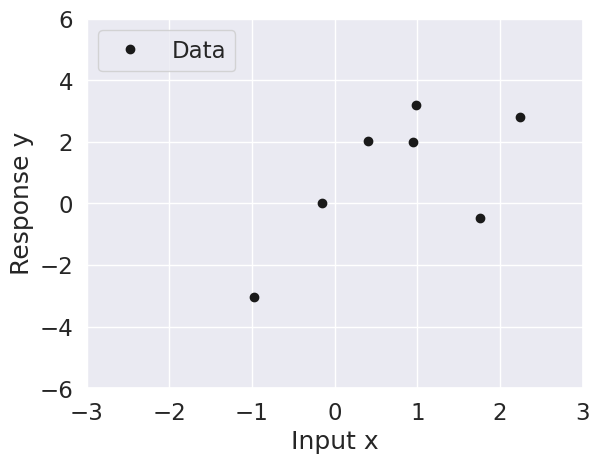

In [4]:
# hyperparameters of the prior
m_prior = np.zeros((2, 1))
S_prior = 1.0*np.identity(2)

# noise variance
sigma2 = 2

# data
N = 8
x_data = np.array([1.764, 0.4, 0.979, 2.241, 1.868, -0.977,  0.95, -0.151])[:, None]
y_data = np.array([-0.464, 2.024, 3.191, 2.812, 6.512, -3.022, 1.99, 0.009])[:, None]

# plot
plt.plot(x_data, y_data, 'k.', label='Data', markersize=12)
plt.xlabel('Input x')
plt.ylabel('Response y')
plt.legend()
plt.xlim((-3, 3))
plt.ylim((-6, 6));

### Task 1: The prior, likelihood and posterior (2 points)

The purpose of this task is to implement the basic building blocks of the linear model. In the cells below, you are given a set of function templates and the task is to complete the implementations as specified below.

*Hint:* look for Rasmussen book section 2.1 (http://www.gaussianprocess.org/gpml/)

**Task 1a**: Implement the multivariate Gaussian density function using numpy (Hint: to avoid numerical problems, always add a small diagonal constant (1e-10) to covariance matrices)

\begin{align}
    \mathcal{N}(\mathbf{x} \mid \boldsymbol{\mu}, \mathbf{\Sigma} ) \sim (2\pi)^{-\frac{D}{2}} | \mathbf{\Sigma} |^{-\frac{1}{2}} \exp\left[-\frac{1}{2}(\mathbf{x} - \boldsymbol{\mu})^\top \mathbf{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu}) \right]
\end{align}

**Reminder:** When $\mathbf{X}$ is a matrix, $|\mathbf{X}|$ refers to its determinant. 


In [5]:
def mvn_pdf(x, mu, Sigma, log=True):
    """ Returns the density of a multivariate Gaussian distribution
    with mean mu and covariance Sigma at point x
    
    Arguments:
    x     -- (Dx1) evaluation point
    mu    -- (Dx1) mean vector
    Sigma -- (DxD) covariance matrix
    log   -- (bool) if true, return log density. If false, return the density. (default=True)
      
    Returns:
    (scalar) density
    """

    # YOUR CODE HERE
    D = mu.shape[0]
    ep = np.eye(D)*(1e-10)
    Sigma = Sigma + ep
    density = ((2*np.pi)**(-0.5*D))*(np.linalg.det(Sigma)**(-0.5))*np.exp(-0.5*((x-mu).T)@np.linalg.inv(Sigma)@(x-mu))
    
    if log:
        density = np.log(density)
        
    return density.item()
    #raise NotImplementedError()
    

#### Let's test the above function

In [6]:
x = np.array([-0.78 , -8.92]).reshape((-1, 1))
m = np.array([0.24, -0.99]).reshape((-1, 1))
Sigma = np.diag([4.02, 4.38])

assert isinstance(mvn_pdf(x, m, Sigma, log=True), float)
assert isinstance(mvn_pdf(x, m, Sigma, log=False), float)
np.testing.assert_allclose(mvn_pdf(x, m, Sigma, log=True), -10.580086)
np.testing.assert_allclose(mvn_pdf(x, m, Sigma, log=False), 2.5417137e-05)

### Do not move or delete the below block. It is used for automatic grading.

**Task 1b**: Implement functions to evaluate log density of the (i) prior, (ii) likelihood and (iii) unnormalized posterior (likelihood times prior) using the <tt>mvn_pdf</tt> function above. Hint: Use the function <tt>predict(x,a,b)</tt> given below

In [7]:
def predict(x, a, b):
    """ returns prediction for inputs x given parameter (a,b)
    
    Arguments:
    x    --  (Nx1) vector of inputs
    a    --  slope parameter
    b    --  intercept parameter
    
    Returns:
    (Nx1) vector of predictions
    """
    return a*x + b


def log_prior(a, b, m, S):
    """ returns the log density of the prior at the points (a,b) given m and S
    
    Arguments:
    a    -- (scalar) slope parameter
    b    -- (scalar) intercept parameter
    m    -- (2x1) The prior mean
    S    -- (2x2) The prior covariance
    
    Returns
    (scalar) log density for the pair (a,b)
    
    """
    
    # YOUR CODE HERE
    w = np.array([[a],[b]])
    density = mvn_pdf(w, m,S)
    return density
    #raise NotImplementedError()


def log_likelihood(x, y, a, b):
    """ returns the log-likelihood for the data (x,y) given the parameters (a,b)
    
    Arguments:
    x    -- (Nx1) vector of inputs
    y    -- (Nx1) vector of responses
    a    -- slope parameter
    b    -- intercept parameter
    
    Returns:
    (scalar) log-likelihood of (x,y) 
    """
    
    # YOUR CODE HERE
    N = x.shape[0]
    Xw = predict(x, a, b)
    Sigma = np.eye(N)*2
    density = mvn_pdf(y, mu = Xw, Sigma=Sigma)
    
    return density
    
    #raise NotImplementedError()
    


def log_posterior(x, y, a, b, m, S):
    """ returns the log posterior at (a,b), given the data (x,y) and the prior parameters (m, S)
    
    Arguments:
    x    -- (Nx1) vector of inputs
    y    -- (Nx1) vector of responses
    a    -- slope parameter
    b    -- intercept parameter
    m    -- (2x1) The prior mean
    S    -- (2x2) The prior covariance
    
    Returns:
    (scalar) log posterior of (x,y)
    """
    
    # YOUR CODE HERE
    log_posterior = log_likelihood(x,y,a,b)+log_prior(a,b,m,S)
    return log_posterior
    
    #raise NotImplementedError()
    



#### Let's test the above functions

In [8]:
a_test = 0.4986
b_test = 0.1951
m_p_test = np.array([-1.43, 0.07]).reshape((2, 1))
S_p_test = np.diag([6.32, 3.88])
x_test = np.array([2.43, 1.82]).reshape((2, 1))
y_test = np.array([-1.46, 1.03]).reshape((2, 1))

np.testing.assert_allclose(log_prior(a_test, b_test, m_p_test, S_p_test), -3.733935)
np.testing.assert_allclose(log_likelihood(x_test, y_test, a_test, b_test), -4.58682955)
np.testing.assert_allclose(log_posterior(x_test, y_test, a_test, b_test, m_p_test, S_p_test), -8.32076455)

### Do not move or delete the below three blocks. It is used for automatic grading.

**Task 1c**: The goal of this task is to make contour plots of the prior density, the likelihood and the posterior as a function of (a,b) in the intervals $-3 \leq a \leq 3$ and $-3 \leq b \leq 3$, respectively, by completing the implementation of the functions: <tt>plot_prior_density</tt>,  <tt>plot_likelihood</tt>,  <tt>plot_posterior_density</tt> given below. 

*Hint:* Check the numpy function <tt>meshgrid</tt> and pyplot function <tt>contour</tt> to plot 2D densities.

The final plot should resemble the below plot:

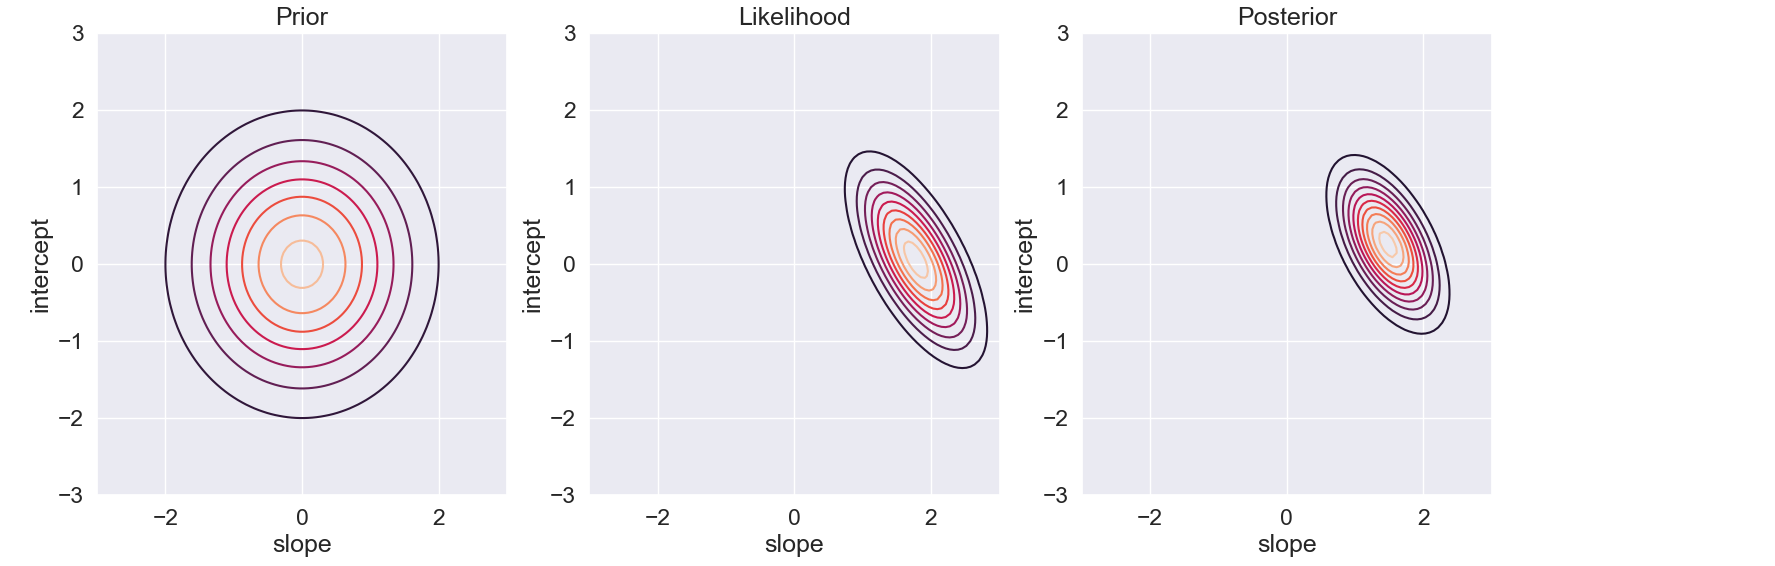


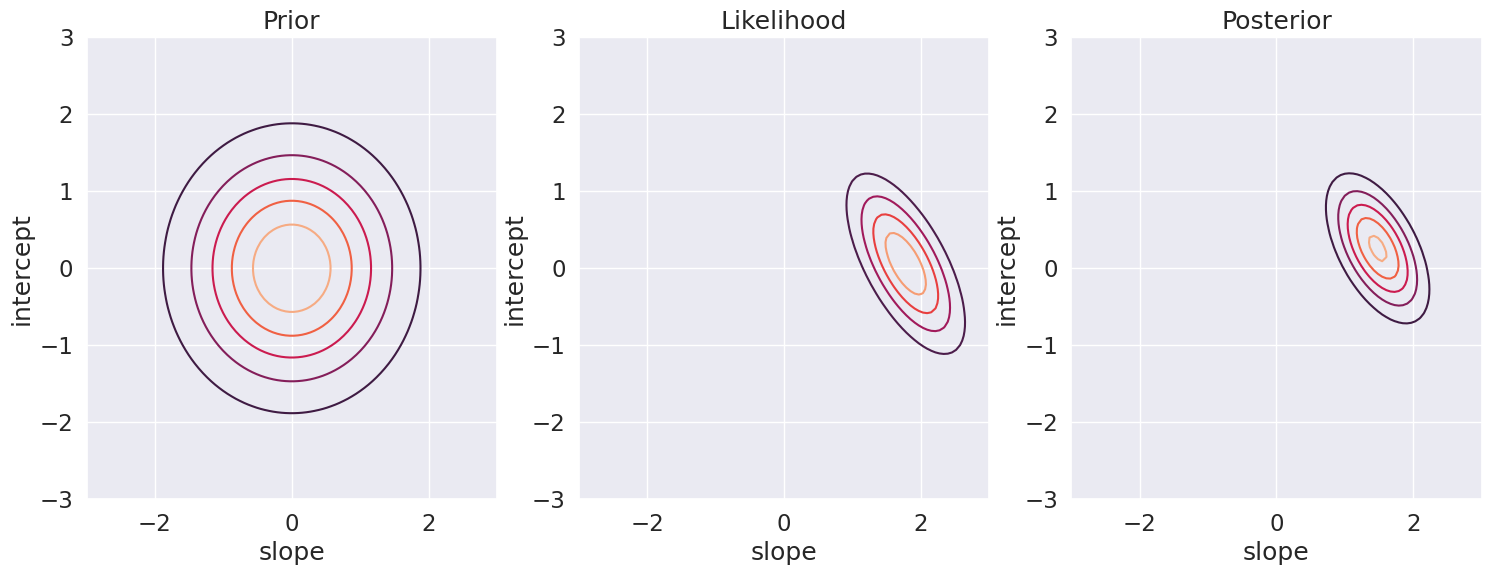

In [9]:
a = np.linspace(-3, 3, 100)
b = np.linspace(-3, 3, 100)

def log_to_density(Z):
    """
    This function converts the log probabilities to probability densities such that they sum to 1.
    """
    Z = Z - np.max(Z)
    Z = np.exp(Z)
    return Z/np.sum(Z)

def plot_prior_density(m, S):
    # YOUR CODE HERE
    X,Y = np.meshgrid(a,b)
    prior_log = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            prior_log[i, j] = log_prior(X[i, j], Y[i, j], m, S)
    prior = log_to_density(prior_log)
    plt.contour(X,Y,prior, levels = 5)
    plt.title("Prior")
    #raise NotImplementedError()
    plt.xlabel('slope')
    plt.ylabel('intercept')
    
    
def plot_likelihood(x, y):
    # YOUR CODE HERE
    X,Y = np.meshgrid(a,b)
    likelihood_log = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            likelihood_log[i, j] = log_likelihood(x,y,X[i, j], Y[i, j])
    likelihood = log_to_density(likelihood_log)
    plt.contour(X,Y,likelihood, levels = 5)
    plt.title("Likelihood")
    #raise NotImplementedError()
    plt.xlabel('slope')
    plt.ylabel('intercept')

def plot_posterior_density(x, y, m, S):
    # YOUR CODE HERE
    X,Y = np.meshgrid(a,b)
    posterior_log = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            posterior_log[i, j] = log_posterior(x,y, X[i, j], Y[i, j], m, S)
    posterior = log_to_density(posterior_log)
    plt.contour(X,Y,posterior, levels = 5)
    plt.title("Posterior")
    #raise NotImplementedError()
    plt.xlabel('slope')
    plt.ylabel('intercept')
    
# plot
plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
plot_prior_density(m_prior, S_prior)
plt.title('Prior')

plt.subplot(1, 3, 2)
plot_likelihood(x_data, y_data)
plt.title('Likelihood')

plt.subplot(1, 3, 3)
plot_posterior_density(x_data, y_data, m_prior, S_prior)
plt.title('Posterior');

### Task 2: Analytical expression of the posterior distribution (2 points)

**Task 2a**: If the prior is $p(\mathbf{w}) \sim \mathcal{N}(\mathbf{m}, \mathbf{S})$, likelihood model is Gaussian with zero mean and $\sigma^2$ variance, the data set is $(\mathbf{X}, \mathbf{y})$ then the posterior is written as $p(\mathbf{w} \mid \mathbf{y}) \sim \mathcal{N}\left(\mathbf{w} \mid \mu, \Sigma\right)$.

Derive the posterior and answer the question below.

#### **Write your derivation here**

<sub>
Hints:

1. Use Bayes rule to obtain an expression for the posterior $p(\mathbf{w}\big|\mathbf{y})$ in terms of the prior, likehood and marginal likelihood
2. Take the logarithm on both sides and expand the right hand side
3. Conclude that only a subset of the terms depends on $\mathbf{w}$. Replace all terms independent of $\mathbf{w}$ with a constant
4. Argue that the posterior distribution must be Gaussian as the remaining terms on the right hand side is a quadratic function of $\mathbf{w}$. 
5. Determine the posterior mean and covariance by 'completing the square' or by comparing the coefficients of the quadractic functions to the logarithm of a multivariate Guassian distribution with mean $\mu$ and covariance $\Sigma$.
</sub>



![](Images/p2.1.jpg)
![](Images/p2.2.jpg)
![](Images/p2.3.jpg)
![](Images/p2.4.jpg)


##### What is the correct value of $\mu$ and $\Sigma$?

**1)** $\Sigma = \left(\frac{1}{\sigma^2}\mathbf{X}^\top\mathbf{X} + \mathbf{S}^{-1}\right)$ and $\mu = \Sigma\left(\frac{1}{\sigma^2}\mathbf{X}^\top\mathbf{y} + \mathbf{S}^{-1}\mathbf{m}\right)$

**2)** $\Sigma = \left(\frac{1}{\sigma^2}\mathbf{X}^\top\mathbf{X} + \mathbf{S}^{-1}\right)^{-1}$ and $\mu = \left(\frac{1}{\sigma^2}\mathbf{X}^\top\mathbf{y} + \mathbf{S}^{-1}\mathbf{m}\right)$

**3)** $\Sigma = \left(\frac{1}{\sigma^2}\mathbf{X}^\top\mathbf{X} + \mathbf{S}^{-1}\right)^{-1}$ and $\mu = \Sigma\left(\frac{1}{\sigma^2}\mathbf{X}^\top\mathbf{y} + \mathbf{S}^{-1}\mathbf{m}\right)$

**4)** $\Sigma = \left(\frac{1}{\sigma^2}\mathbf{X}^\top\mathbf{X} + \mathbf{S}\right)^{-1}$ and $\mu = \Sigma\left(\frac{1}{\sigma^2}\mathbf{X}^\top\mathbf{y} + \mathbf{S}\mathbf{m}\right)$

In [10]:
a_2a = 3  # TASK: Replace None with your answer (1, 2, 3, 4)

In [11]:
assert a_2a in [1, 2, 3, 4]

### Do not move or delete the below block. It is used for automatic grading.

**Task 2b**: Complete the implementation of the function for computing the analytical posterior distribution given below.

*Hint:* The function <tt>design_matrix</tt> maps from a vectors of input $\mathbf{x}$ to the design matrix $\mathbf{X}$.

In [12]:
def design_matrix(x):
    """ returns the design matrix for a vector of input values x 
    
    Arguments:
    x    -- (Nx1) vector of inputs
    
    Returns:
    (Nx2) design matrix
    
    """
    X = np.column_stack((x, np.ones(len(x))))
    return X

def compute_posterior(x, y, m, S, sigma2):
    """ return the posterior mean and covariance of w given (x,y) 
    and hyperparameters m, S and sigma2
    
    Arguments:
    x      -- (Nx1) vector of inputs
    y      -- (Nx1) vector of responses
    m      -- (Dx1) prior mean
    S      -- (DxD) prior covariance
    sigma2 -- (scalar) noise variance
    
    Returns:
    mu     -- (Dx1) posterior mean
    Sigma  -- (DxD) posterior covariance
    
    """
    
    X = design_matrix(x)
    
    # YOUR CODE HERE
    inv_Sigma = (X.T@X)/sigma2 + np.linalg.inv(S)
    Sigma = np.linalg.inv(inv_Sigma)
    mu = Sigma@((X.T@y)/sigma2 + np.linalg.inv(S)@m)
    #raise NotImplementedError()
    
    return mu, Sigma

#### Let's test the above function

In [13]:
x_test = np.array([3.06, -0.59]).reshape((2, 1))
y_test = np.array([3.35, 5.75]).reshape((2, 1))
m_prior_test = np.array([-0.47, -0.85]).reshape((2, 1))
S_prior_test = np.diag([4.86, 2.64])

expected_val_mu = np.array([-0.114923, 3.169421]).reshape((2, 1))
expected_val_S =  np.array([[0.252819, -0.226453], [-0.226453, 0.928112]]).reshape((2, 2))

val_mu, val_S = compute_posterior(x_test, y_test, m_prior_test, S_prior_test, sigma2)

np.testing.assert_array_almost_equal(val_mu, expected_val_mu)
np.testing.assert_array_almost_equal(val_S, expected_val_S)

### Do not move or delete the below block. It is used for automatic grading.

**Task 2c**: Using the function above, compute the posterior mean and covariance for the data set $(\mathbf{x\_data}, \mathbf{y\_data})$. Plot the resulting density and check that it matches the posterior distribution from task 1d.

In [25]:
a = np.linspace(-3, 3, 100)
b = np.linspace(-3, 3, 100)
A, B = np.meshgrid(a, b)
AB = np.column_stack((A.ravel(), B.ravel()))

mu, Sigma = compute_posterior(x_data, y_data, m_prior, S_prior, sigma2)
log_posterior_vals = None  # TASK: Populate this with the log PDF values for the grid. It should be a numpy array.

# YOUR CODE HERE
log_posterior_vals = np.zeros(A.shape)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        log_posterior_vals[i,j] = log_posterior(x_data,y_data, A[i, j], B[i, j], mu, Sigma)
#raise NotImplementedError()


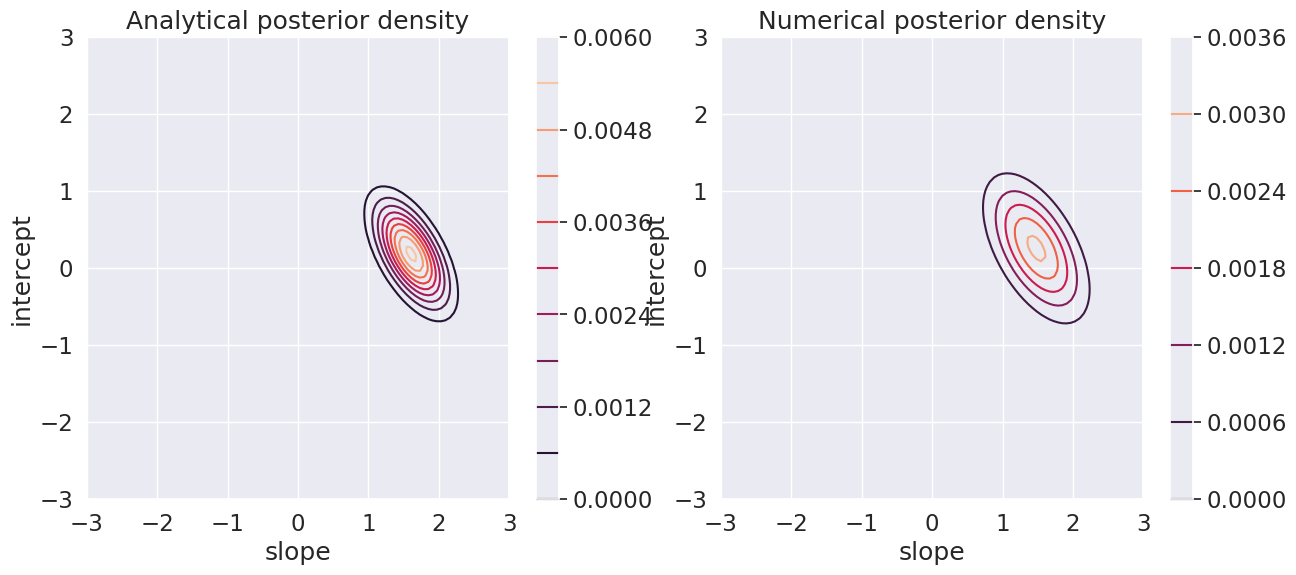

In [26]:
assert isinstance(log_posterior_vals, np.ndarray)
assert log_posterior_vals.shape == (100, 100)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.contour(a, b, log_to_density(log_posterior_vals), 10)
plt.title('Analytical posterior density')
plt.colorbar()
plt.xlabel('slope')
plt.ylabel('intercept');

plt.subplot(1, 2, 2)
plot_posterior_density(x_data, y_data, m_prior, S_prior)
plt.title('Numerical posterior density')
plt.colorbar()
plt.xlabel('slope')
plt.ylabel('intercept');

### Do not move or delete the below block. It is used for automatic grading.

### Task 3: Combining all of the above (2 points)

In this task, you will use all the functions you implemented above to perform compute the posterior distribution $p\left(\mathbf{w}|\mathbf{y}\right)$ for various sizes of $N$. The cell below analyses the data set using $N = \left\lbrace 1, 2, 10, 20 \right\rbrace$ data points, where the columns visualise (i) data and sample functions, (ii) the prior, (iii) the likelihood and (iv) posterior. 

**Task 3a**: The code below is 100% complete, and works without issues if you have implemented all previous functions/tasks. You should see 4 visualisations.


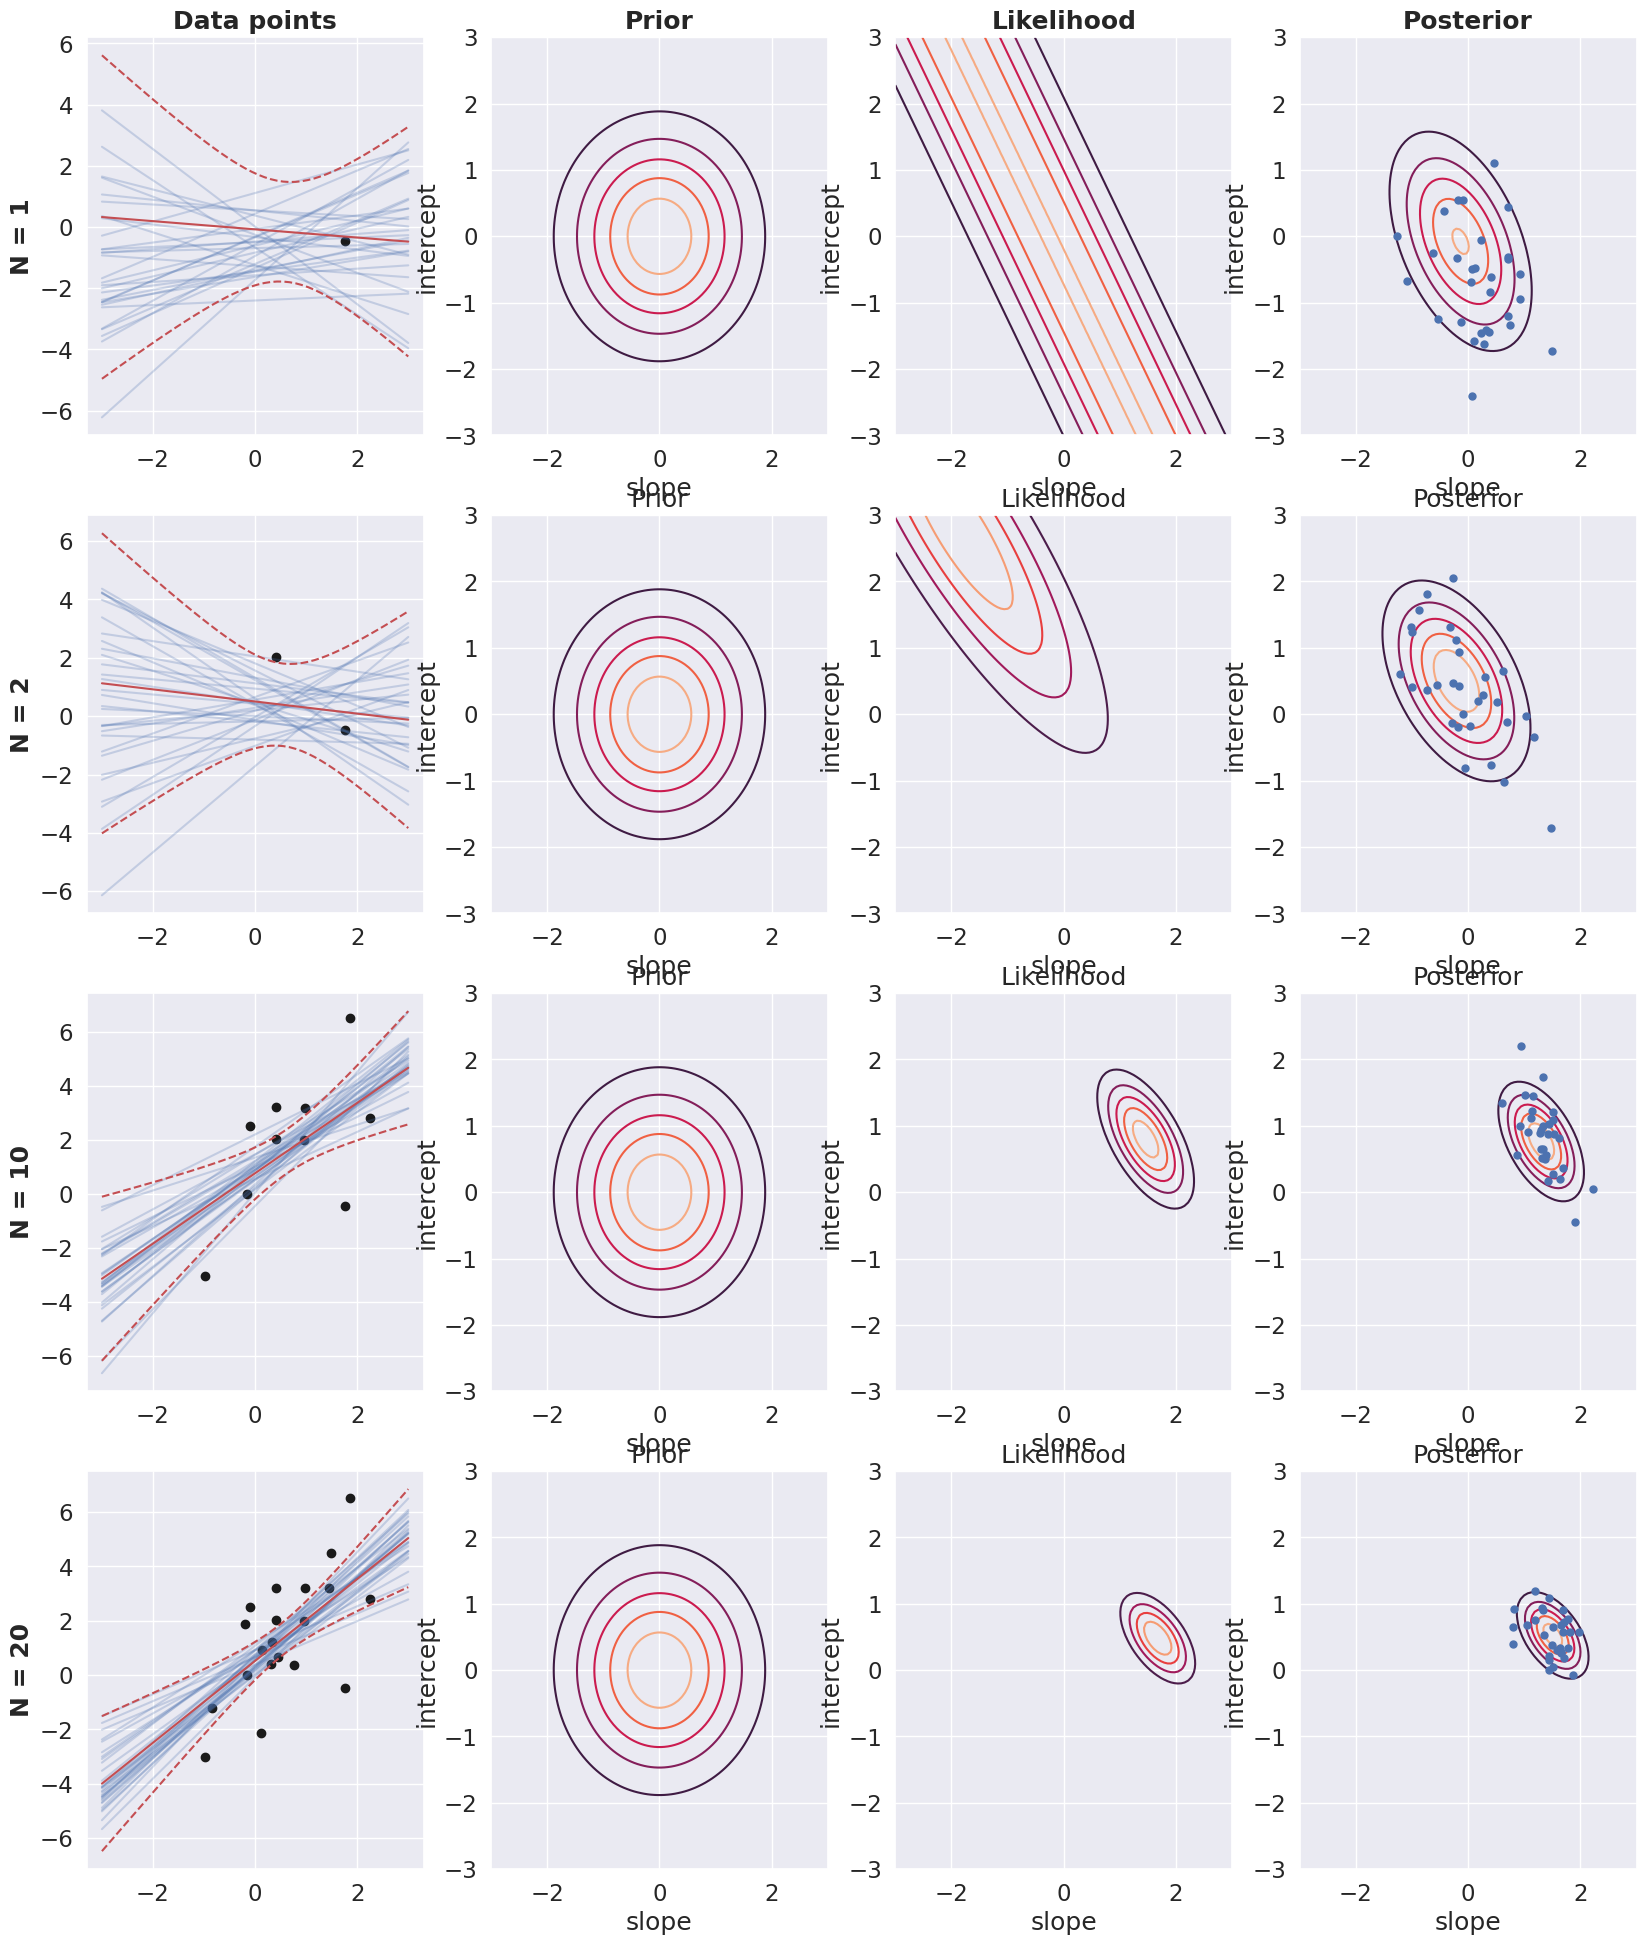

In [52]:
def generate_mvn_samples(mu, Sigma, M):
    """ return samples from a multivariate normal distribution N(mu, Sigma)

    Arguments:
    mu      -- (Dx1) mean vector
    Sigma   -- (DxD) covariance matrix
    M       -- (scalar) number of samples
    
    Returns:
    (DxM) matrix, where each column corresponds to a sample
    """
    
    jitter = 1e-8
    D = len(mu)
    L = np.linalg.cholesky(Sigma + jitter*np.identity(D))
    zs = np.random.normal(0, 1, size=(D, M))
    fs = mu + np.dot(L, zs)
    return fs

def compute_f_posterior(x, mu, Sigma):
    """ compute the posterior distribution of f(x) wrt. posterior distribution N(mu, Sigma) 
    
    Arguments:
    x      -- (Nx1) vector of inputs
    mu     -- (2x1) mean vector
    Sigma  -- (2x2) covariance matrix
    
    Returns:
    mu_f   -- (Nx1) vector of pointwise posterior means at x
    var_f  -- (Nx1) vector of pointwise posterior variances at x
    
    """
    
    X = np.column_stack((x, np.ones(len(x))))
    mu_f = np.dot(X, mu)
    var_f = np.diag(np.dot(np.dot(X, Sigma), X.T))[:, None]
        
    return mu_f, var_f


np.random.seed(21340)

# New data set with more data points
N_2 = 20
x_2 = np.array([1.764, 0.4, 0.979, 2.241, 1.868, -0.977,  0.95, -0.151, -0.103, 0.411, 0.144, 1.454, 0.761, 0.122,
              0.444, 0.334, 1.494, -0.205,  0.313, -0.854])[:, None]
y_2 = np.array([-0.464, 2.024, 3.191, 2.812, 6.512, -3.022, 1.99, 0.009, 2.513, 3.194, 0.935, 3.216, 0.386, -2.118,
               0.674, 1.222, 4.481, 1.893, 0.422, -1.209])[:, None]

xp = np.linspace(-3, 3, 50)[:, None]

plt.figure(figsize=(20, 30))    
for idx_n, n in enumerate([1, 2, 10, 20]):
    
    # compute posterior & generate samples
    mu, Sigma = compute_posterior(x_2[:n, :], y_2[:n, :], m_prior, S_prior, sigma2)
    ahat, bhat = generate_mvn_samples(mu, Sigma, M=30)
  
    # plot
    plt.subplot2grid((5, 4), (idx_n, 0))
    plt.plot(x_2[:n, :], y_2[:n, :], 'k.', markersize=12)
    plt.ylabel('N = %d' % n, fontweight='bold')    
    for (ai, bi) in zip(ahat, bhat):
        plt.plot(xp, predict(xp, ai, bi), 'b-', alpha=0.25)
        
    mu_f, var_f = compute_f_posterior(xp, mu, Sigma)
    std_f = np.sqrt(var_f)

    plt.plot(xp, mu_f, 'r')
    plt.plot(xp, mu_f + 2*std_f, 'r--')
    plt.plot(xp, mu_f - 2*std_f, 'r--')
    
    if idx_n == 0:
        plt.title('Data points', fontweight='bold')
        
    plt.subplot2grid((5, 4), (idx_n, 1))
    plot_prior_density(m_prior, S_prior)
    
    if idx_n == 0:
        plt.title('Prior', fontweight='bold')

    plt.subplot2grid((5, 4), (idx_n, 2))
    plot_likelihood(x_2[:n, :], y_2[:n, :])
       
    if idx_n == 0:
        plt.title('Likelihood', fontweight='bold')
    
    plt.subplot2grid((5, 4), (idx_n, 3))
    plot_posterior_density(x_2[:n, :], y_2[:n, :], m_prior, S_prior)
    plt.plot(ahat, bhat, 'b.', markersize=10)
    
    if idx_n == 0:
        plt.title('Posterior', fontweight='bold')


**Task 3b**: Study the code and plots above and answer the below questions: 

**Q3.1:** Is there a relation between the blue lines in the first column and the blue dots in the fourth column?

In [53]:
a3_1 = True  # TASK: Replace None with True or False answer.

**Q3.2:** As the number of data points increase, the effect of prior on the posterior increases?

In [54]:
a3_2 = False  # TASK: Replace None with True or False answer.

**Q3.3:** As the number of data points increase, the effect of likelihood in the posterior increases?

In [55]:
a3_3 = True  # TASK: Replace None with True or False answer.

**Q3.4** The number of data points have no effect on the prior.

In [56]:
a3_4 = True  # TASK: Replace None with True or False answer.

In [57]:
assert isinstance(a3_1, bool)
assert isinstance(a3_2, bool)
assert isinstance(a3_3, bool)
assert isinstance(a3_4, bool)

### Do not move or delete the below blocks. It is used for automatic grading.

### Task 4: After answering all the questions, kindly use the validate option in the toolbar to validate the notebook and be sure that there are no errors.